<a href="https://colab.research.google.com/github/PARULCHUTANIPC/parul/blob/p1/vgg16_dogs%26_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
#from scipy.interpolate import spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
import zipfile
from google.colab import drive
drive.mount("/content/drive")

In [13]:
keras.__version__

'2.4.3'

In [14]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

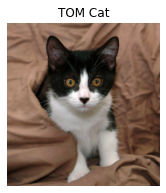

In [24]:

img = load_img('/content/drive/MyDrive/PetImages/train images/Cat/1002.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('TOM Cat')
plt.show()

In [21]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

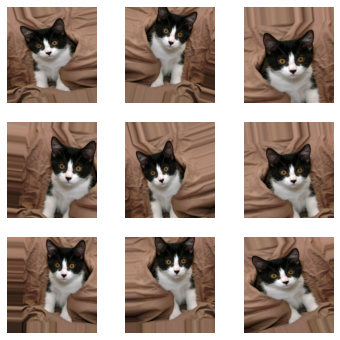

In [22]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

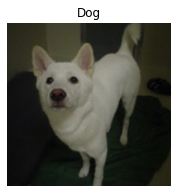

In [34]:
img1 = load_img('/content/drive/MyDrive/PetImages/train images/Dog/11111.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Dog')
plt.show()

In [35]:
x3 = img_to_array(img1)
x4 = x.reshape((1,) + x.shape)

TypeError: ignored

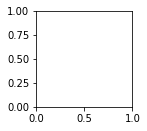

In [38]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x4, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x4.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

In [62]:
# default settings
img_width, img_height = 224, 224

train_dir = '/content/drive/MyDrive/PetImages/train images'
validate_dir = '/content/drive/MyDrive/PetImages/test images'
nb_epochs = 2
batch_size = 1
nb_classes = len(glob.glob(train_dir + '/*'))

In [40]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

24935


In [41]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

202


In [42]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [43]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [44]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 24933 images belonging to 2 classes.


In [45]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 202 images belonging to 2 classes.


In [46]:
# this will copy the pretrained weights to our kernel
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists
cp: cannot stat '../input/keras-pretrained-models/*notop*': No such file or directory
cp: cannot stat '../input/keras-pretrained-models/imagenet_class_index.json': No such file or directory


In [53]:
# set up transfer learning on pre-trained ImageNet VGG16 model - remove fully connected layer and replace
# with softmax for classifying 10 classes
vgg16_model = VGG16(weights = 'imagenet', include_top = False)
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)


In [58]:
#model = Model(vgg16_model.input,  = predictions)
model = Model(inputs=vgg16_model.input, outputs=predictions)

In [59]:
# freeze all layers of the pre-trained model
for layer in vgg16_model.layers:
    layer.trainable = False

In [60]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [67]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    epochs = nb_epochs,
    steps_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    validation_steps = nb_validate_samples)
    #class_weight='auto')
print('Training time: %s' % (now() - t))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
  298/24935 [..............................] - ETA: 3:47:26 - loss: 0.9354 - accuracy: 0.5762

UnknownError: ignored

In [ ]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
# save transfer learning model for offline prediction purposes
model.save('dogsandcat_vgg16_model_tl.h5')

In [ ]:
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y1))
plt.show()

In [ ]:
validate_generator.total_batches_seen

In [ ]:
predict_files = glob.glob("../input/cat-and-dog/test_set/test_set/cats/*.jpg")

In [ ]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [ ]:

predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])


In [ ]:
final = pd.DataFrame()
final["id"] = image_id
final["Cats"] = predictor 
final.head(100)

In [ ]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [ ]:
final["Cats"] = final["Cats"].apply(lambda x: classes[x])
final.head(100)